# Tally slurm total GPU hours for an account

This assumes that you have run

```bash
sacct -A pli --format=JobID,Account,AllocTRES%30,Elapsed  --allusers --json > sacct_pli.json    
```

on the server, printing out all jobs for the `pli` account.

In [113]:
import json
from pathlib import Path
import numpy as np
from pandas import DataFrame as DF
import pandas as pd

In [114]:
json_data = Path("..", 'data',  'sacct_pli.json')

assert json_data.exists()

In [115]:
data = json.loads(json_data.read_text())

In [116]:
class Parser:
    def parse(self, data: dict) -> DF:
        records = []
        for job in data["jobs"]:
            n_gpus = self._get_n_gpus(job)
            records.append({
                "n_gpus": n_gpus,
                "elapsed": job["time"]["elapsed"],
                "start_time": job["time"]["start"],
            })
        df = pd.DataFrame.from_records(records)
        self._augment_df(df)
        return df


    @staticmethod 
    def _get_n_gpus(job_data: dict) -> int:
        n_gpus = 0
        for allocation in job_data["tres"]["allocated"]:
            if allocation["type"] == "gres" and allocation["name"] == "gpu":
                n_gpus += int(allocation["count"])
        return n_gpus
    
    @staticmethod
    def _augment_df(df: DF) -> None:
        df["gpu_time"] = df["n_gpus"] * df["elapsed"]
        df['start_time'] = pd.to_datetime(df['start_time'], unit='s')
   

In [117]:
df = Parser().parse(data)

In [118]:
df

,n_gpus,elapsed,start_time,gpu_time
0,1,4,2024-01-18 20:38:41,4
1,1,40,2024-01-18 20:51:45,40
2,4,4017,2024-01-18 21:02:40,16068
3,1,13,2024-01-18 22:09:33,13
4,4,4219,2024-01-18 22:11:01,16876
...,...,...,...,...
2551,0,0,2106-02-07 06:28:14,0
2552,0,0,2106-02-07 06:28:14,0
2553,0,0,2106-02-07 06:28:14,0
2554,0,0,2106-02-07 06:28:14,0


Text(0.5, 0, 'GPU hours [h]')

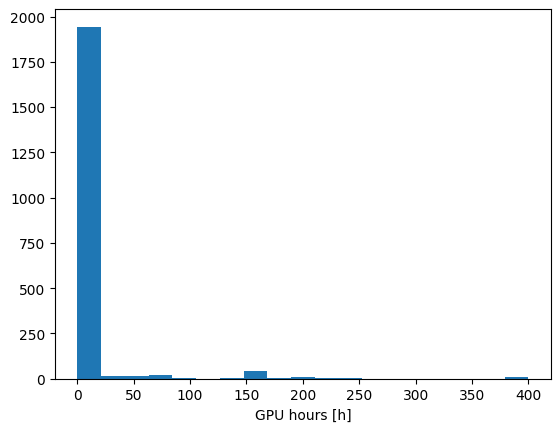

In [119]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
ax.hist((df[df["n_gpus"] > 0])["gpu_time"] / 3600, bins=np.linspace(0, 400, 20), )
ax.set_xlabel("GPU hours [h]")